# MLS Week-4 : Training, Tuning and Deployment

### Connect to the workspace

First, we'll need to connect to your Azure Machine Learning workspace. The Azure Machine Learning workspace is the top-level resource for the service. It provides you with a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We're using DefaultAzureCredential to get access to the workspace. This credential should be capable of handling most Azure SDK authentication scenarios.

In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

Next, get a handle to the workspace by providing your Subscription ID, Resource Group name, and workspace name. To find these parameters:

* Look in the upper-right corner of the Azure Machine Learning studio toolbar for your workspace name.
* Select your workspace name to show your Resource Group and Subscription ID.
* Copy the values for Resource Group and Subscription ID into the code.

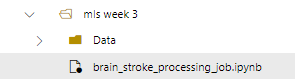

In [2]:
from IPython import display
display.Image("Image/Image1.png")

In [3]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="6793e723-756c-4c5d-84c0-812f1bb4c679", #Provide your subscription ID as shown in the above screenshot
    resource_group_name="JuvlinResourceGroup", #Provide your Resource Group as shown in the above screenshot
    workspace_name="JuvlinWorkspace",
)

### Create a compute resource to run the job

Azure Machine Learning needs a compute resource to run a job. This resource can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark.

We only need a basic cluster for this task; thus, we'll pick a Standard_D2_v3 model with 2 CPU cores and 7 GB RAM to create an Azure Machine Learning compute.



In [4]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster-E2E"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

You already have a cluster named cpu-cluster-E2E, we'll reuse it as is.
AMLCompute with name cpu-cluster-E2E is created, the compute size is STANDARD_D2_V3


**Note: Go to the "Compute" on the left --> "Compute clusters", to check the new cluster created for the processing job.  **

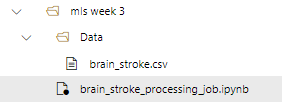

In [5]:
display.Image("Image/Image2.png")

### Create a job environment

To run an Azure Machine Learning job, you'll need an environment. It encapsulates the dependencies (such as software runtime and libraries) needed to run our machine learning training script on our compute resource. This environment is similar to a Python environment on our local machine.

We'll create a custom environment for our jobs, using a Conda YAML file.





#### Create a custom environment

To create your custom environment, we'll define your Conda dependencies in a YAML file. First, create a directory for storing the file. We've named the directory env.

In [6]:
import os

## Set the name of the directory we want to create
dependencies_dir = "./env"

# # The os.makedirs() function creates a directory
# exist_ok=True means that the function will not raise an exception if the directory already exists
os.makedirs(dependencies_dir, exist_ok=True)

Then, create the file in the dependencies directory. In this example, we've named the file conda.yml.

In [7]:
%%writefile {dependencies_dir}/conda.yaml
name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.23.2
  - scipy=1.7.1
  - pip:  
    - mlflow==2.8.1
    - azureml-mlflow==1.51.0
    - azureml-inference-server-http
    - azureml-core==1.49.0
    - cloudpickle==1.6.0

Overwriting ./env/conda.yaml


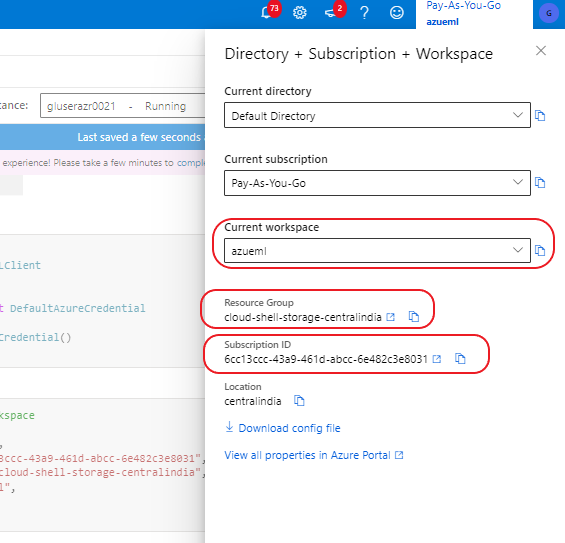

In [8]:
display.Image("Image/Image3.png")

The specification contains some usual packages (such as numpy and pip) that you'll use in our job.

Next, use the YAML file to create and register this custom environment in our workspace. The environment will be packaged into a Docker container at runtime.

In [9]:
# Import the Environment class from the azure.ai.ml.entities module
from azure.ai.ml.entities import Environment


# Set the name of the custom environment we want to create
custom_env_name = "machine_learning_E2E"

# Create an Environment object with the specified properties
job_env = Environment(
    name=custom_env_name,
    description="Custom environment for machine learning task",
    conda_file=os.path.join(dependencies_dir, "conda.yaml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)
job_env = ml_client.environments.create_or_update(job_env)

# Print out some information about the registered environment
print(
    f"Environment with name {job_env.name} is registered to workspace, the environment version is {job_env.version}"
)

Environment with name machine_learning_E2E is registered to workspace, the environment version is 5


**Note: We can check the environment created for the job from the left**

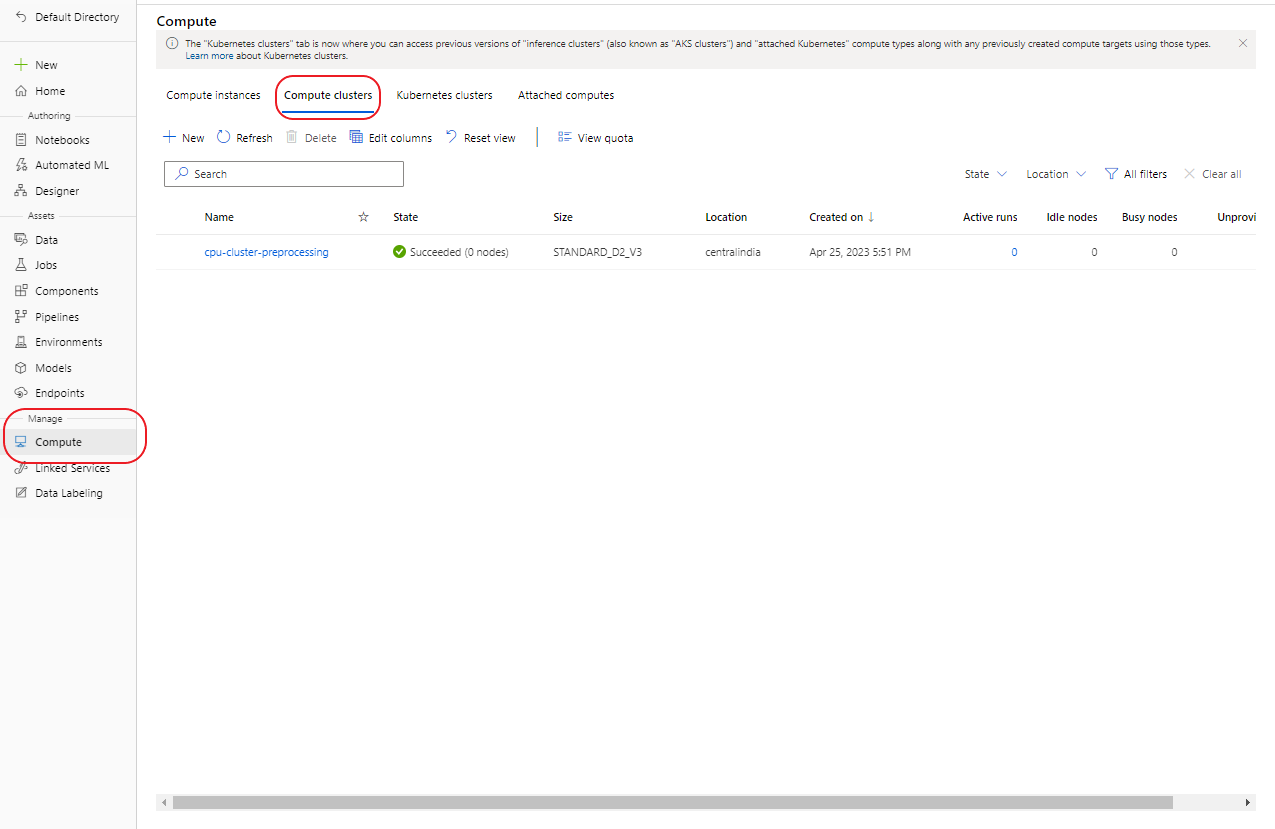

In [10]:
display.Image("Image/Image4.png")

### Configure and submit your training job

#### Prepare the training script

In [11]:
# To use the training script, first create a directory where you will store the file.
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

**Next, create the script file in the source directory. Description of the script is as follows:**

* The script defines a command-line interface for training a Decision Tree model on a given input dataset, logs the results to MLflow, saves the trained model as an MLflow artifact, and registers it with the model registry.


* The script first imports necessary libraries for building and evaluating the Decision Tree model, as well as libraries for logging the model and its parameters and metrics to MLflow.


* Next, the script defines a main() function that sets up the command-line interface using the argparse library. The function reads in the input dataset from a specified path, sets the model parameters based on user input, and trains the Decision Tree model using the training data. The script then evaluates the trained model on a holdout test set and logs the resulting accuracy and confusion matrix to MLflow.


* Finally, the script registers the trained model with the MLflow model registry by logging it as an MLflow artifact and then saving it to disk using mlflow.sklearn.log_model() and mlflow.sklearn.save_model(), respectively. The registered model can be deployed and served using the MLflow model serving capabilities.

In [12]:
%%writefile {src_dir}/main.py

# importing necessary libraries
import argparse
import os
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import mlflow
import mlflow.sklearn

# create an argument parser to take input arguments from command line
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument('--criterion', type=str, default='gini',
                        help='The function to measure the quality of a split')
    parser.add_argument('--max-depth', type=int, default=None,
                        help='The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples.')
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--registered_model_name", type=str, help="model name")

    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    # print input arguments
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    # load input data
    print("input data:", args.data)
    df = pd.read_csv(args.data)

    # log input hyperparameters

    mlflow.log_param('Criterion', str(args.criterion))
    mlflow.log_param('Max depth', str(args.max_depth))

    # split the data into training and testing sets
    train_df, test_df = train_test_split(
        df,
        test_size=args.test_train_ratio,
    )


    # training a decision tree classifier


    # Extracting the label column
    y_train = train_df.pop("class")

    # convert the dataframe values to array
    X_train = train_df.values

    # Extracting the label column
    y_test = test_df.pop("class")

    # convert the dataframe values to array
    X_test = test_df.values

    # initialize and train a decision tree classifier
    tree_model = DecisionTreeClassifier(criterion=args.criterion, max_depth=args.max_depth)
    tree_model = tree_model.fit(X_train, y_train)
    tree_predictions = tree_model.predict(X_test)

    # compute and log model accuracy
    accuracy = tree_model.score(X_test, y_test)
    print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(accuracy))
    mlflow.log_metric('Accuracy', float(accuracy))

    # creating a confusion matrix
    cm = confusion_matrix(y_test, tree_predictions)
    print(cm)

    # set the name for the registered model
    registered_model_name="pima_decisiontree_model"

    ##########################
    #<save and register model>
    ##########################

    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=tree_model,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name
    )

    # # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=tree_model,
        path=os.path.join(registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
   
    # end MLflow tracking
    mlflow.end_run()

if __name__ == '__main__':
    main()



Overwriting ./src/main.py


#### Configure the command

We'll use the general purpose command to run the training script and perform your desired tasks. Create a Command object to specify the configuration details of your training job.


**Note: Create a data folder to store the pima.csv data which will be used for the job**

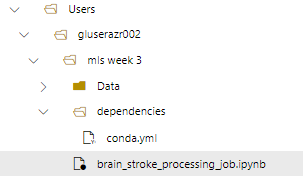

In [13]:
display.Image("Image/Image5.png")

**The inputs parameter specifies the input data and the hyperparameters for the decision tree model. **

* The data input is a URI to the Pima Indian diabetes dataset in a CSV format.


* The test_train_ratio parameter is set to 0.3, which means that 30% of the data will be used for testing and the rest for training. 


* The criterion parameter is set to "gini", which is the splitting criterion for the decision tree model.


* The max_depth parameter is set to 2, which is the maximum depth of the decision tree.

In [14]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="./data/pima.csv", # The path to the input data file
        ),
        test_train_ratio=0.3, # The ratio of the data to be used for testing
        criterion="gini", # The criterion used to measure the quality of a split
        max_depth=2, # The maximum depth of the decision tree
    ),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python main.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}} --criterion ${{inputs.criterion}} --max-depth ${{inputs.max_depth}}",
    # Specify the environment to be used for the job
    environment="machine_learning_E2E@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-E2E",
    # Specify the name of the experiment for the job
    experiment_name="train_decision_tree_pima_prediction",
     # Specify the display name for the job
    display_name="decision_tree_pima_prediction",
)


#### Submit the job

In [15]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
train_decision_tree_pima_prediction,careful_vase_bzrw2vx6q2,command,Starting,Link to Azure Machine Learning studio


**Note 1: We can check the status and outcome of the training job by going to the "Jobs" on the left --> Metrics.**

In [16]:
# display.Image("Image/Image6.1.png")

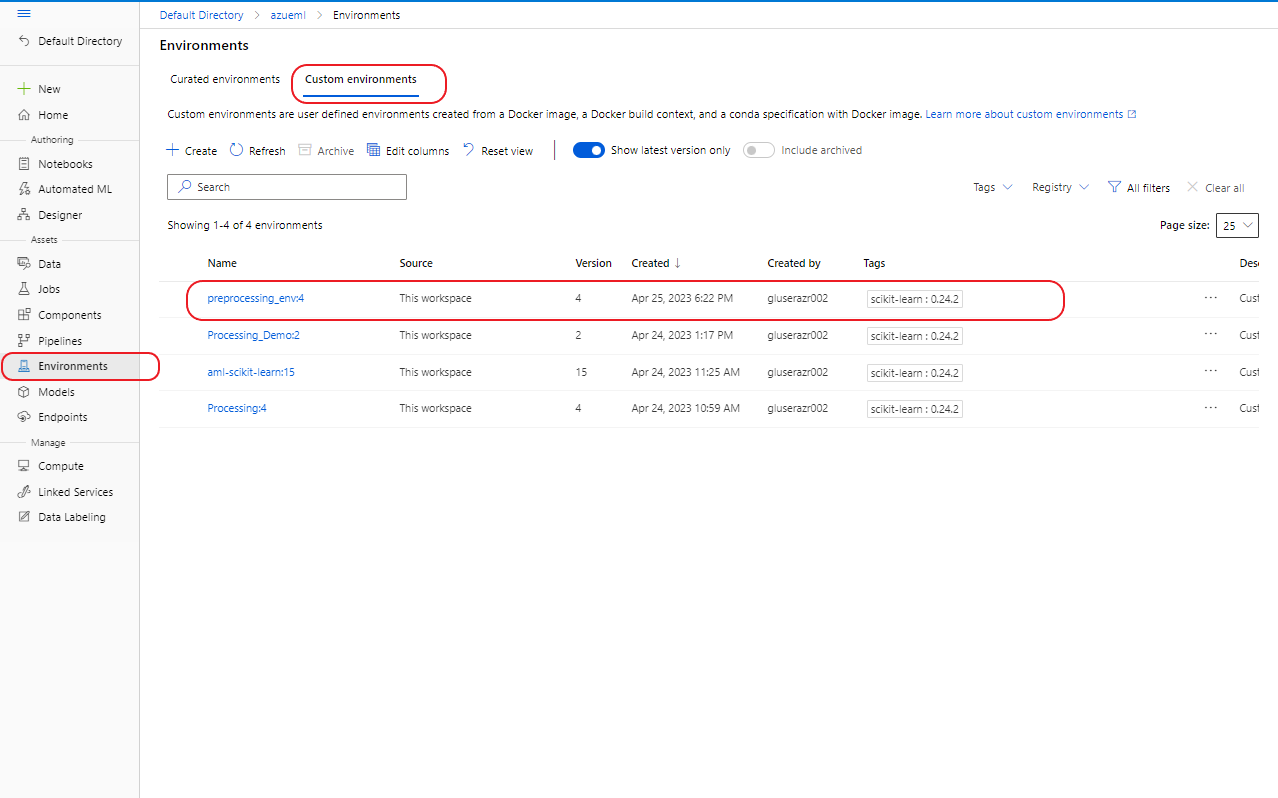

In [17]:
display.Image("Image/Image6.png")

**Note 2: We can check for registered model by clicking on the Models on the left.**

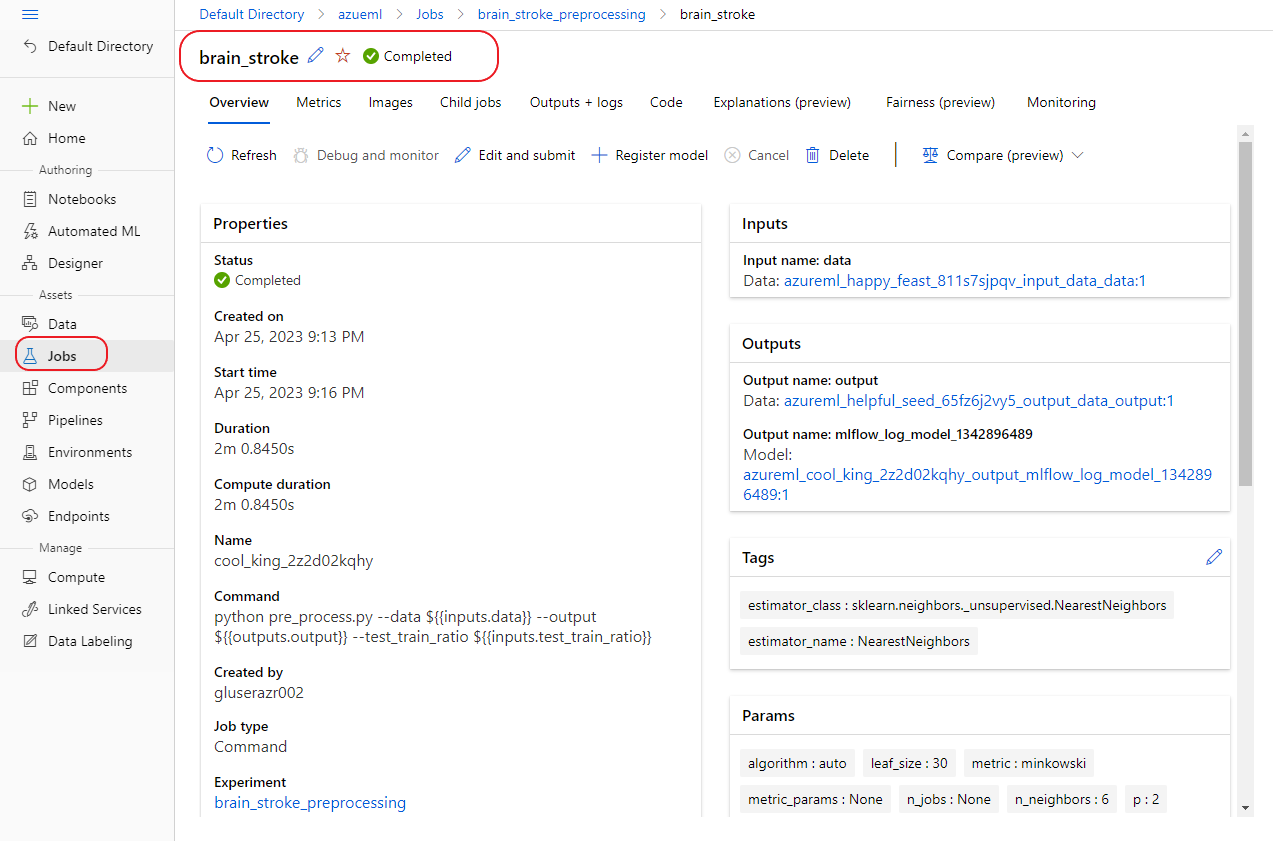

In [18]:
display.Image("Image/Image7.png")

**Note: What happens during job execution: **

As the job is executed, it goes through the following stages:

* **Preparing**: A docker image is created according to the environment defined. The image is uploaded to the workspace's container registry and cached for later runs. Logs are also streamed to the run history and can be viewed to monitor progress. If a curated environment is specified, the cached image backing that curated environment will be used.

* **Scaling**: The cluster attempts to scale up if the cluster requires more nodes to execute the run than are currently available.

* **Running**: All scripts in the script folder src are uploaded to the compute target, data stores are mounted or copied, and the script is executed. Outputs from stdout and the ./logs folder are streamed to the run history and can be used to monitor the run.



### Tune model hyperparameters

Let's see if we can further improve the accuracy of your model. You can tune and optimize our model's hyperparameters using Azure Machine Learning's sweep capabilities.

**To tune the model's hyperparameters:**

* Define the parameter space in which to search during training. 


* We'll do this by replacing the parameters (criterion and max_depth) passed to the training job with special inputs from the azure.ml.sweep package.

In [19]:
from azure.ai.ml.sweep import Choice

# we will reuse the command_job created before. 
job_for_sweep = job(
    criterion=Choice(values=["gini", "entropy"]),
    max_depth=Choice(values=[2, 4]),
)


* Then, we'll configure sweep on the command job, using some sweep-specific parameters, such as the primary metric to watch and the sampling algorithm to use.


* In the following code we use random sampling to try different configuration sets of hyperparameters in an attempt to maximize our primary metric, Accuracy.

In [20]:
# compute specifies the compute target where the sweep job will run.
# sampling_algorithm specifies the search algorithm to use for hyperparameter tuning.
# primary_metric specifies the metric to optimize during hyperparameter tuning.
# goal specifies whether to maximize or minimize the primary metric.
# max_total_trials specifies the maximum number of trials to run during hyperparameter tuning.
# max_concurrent_trials specifies the maximum number of trials to run concurrently during hyperparameter tuning.

sweep_job = job_for_sweep.sweep(
    compute="cpu-cluster-E2E",
    sampling_algorithm="random",
    primary_metric="Accuracy",
    goal="Maximize",
    max_total_trials=4,
    max_concurrent_trials=1,
)

Now, we can submit this job as before. This time, we'll be running a sweep job that sweeps over your train job.

In [21]:
# create or update the sweep job
returned_sweep_job = ml_client.create_or_update(sweep_job) 

# stream the output and wait until the job is finished
ml_client.jobs.stream(returned_sweep_job.name)

# refresh the latest status of the job after streaming
returned_sweep_job = ml_client.jobs.get(name=returned_sweep_job.name)

RunId: polite_beet_9hc7j4bhxr
Web View: https://ml.azure.com/runs/polite_beet_9hc7j4bhxr?wsid=/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/JuvlinResourceGroup/workspaces/JuvlinWorkspace

Streaming azureml-logs/hyperdrive.txt

[2024-10-28T02:11:05.7418381Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-10-28T02:11:06.2713412Z][SCHEDULER][INFO]Scheduling job, id='polite_beet_9hc7j4bhxr_0' 
[2024-10-28T02:11:07.1615408Z][SCHEDULER][INFO]Successfully scheduled a job. Id='polite_beet_9hc7j4bhxr_0' 
[2024-10-28T02:20:40.3743725Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-10-28T02:20:40.5521978Z][SCHEDULER][INFO]Scheduling job, id='polite_beet_9hc7j4bhxr_1' 
[2024-10-28T02:20:41.4604283Z][SCHEDULER][INFO]Successfully scheduled a job. Id='polite_beet_9hc7j4bhxr_1' 
[2024-10-28T02:22:41.8445533Z][GENERATOR][DEBUG]Sampled 1 jobs from search space 
[2024-10-28T02:22:42.0808036Z][SCHEDULER][INFO]Scheduling job, id='polite_beet_9hc7j4bhxr_2' 
[2024-10

**Note 1: Go to the Jobs --> Select the experiment name --> Click on Trends, to observe the tuning outcomes.**

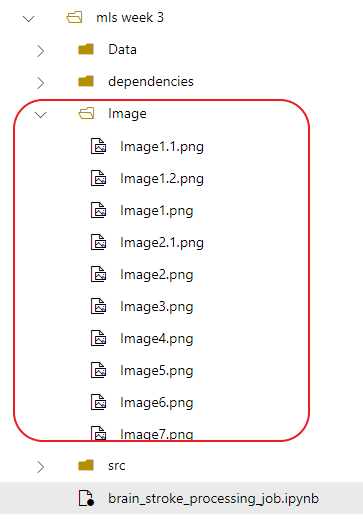

In [22]:
display.Image("Image/Image8.png")

**Note 2: Go to the Models on the left to observe the tuned registered models**

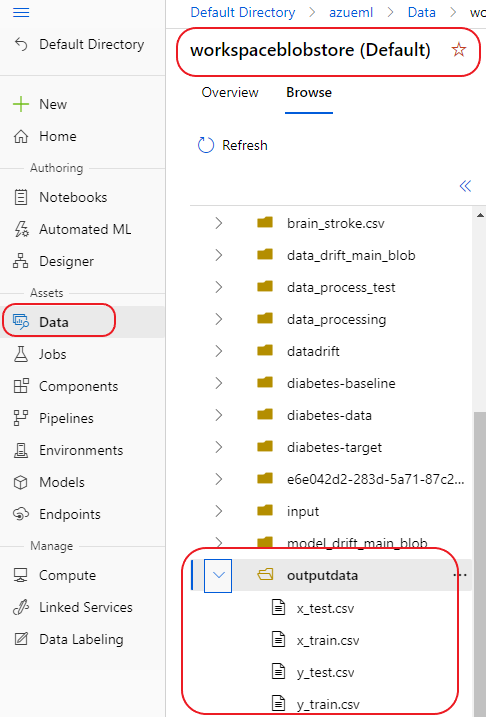

In [23]:
display.Image("Image/Image9.png")

### Find and register the best model

Once all the runs complete, we can find the run that produced the model with the highest accuracy.

In [24]:
from azure.ai.ml.entities import Model

if returned_sweep_job.status == "Completed":

    # First let us get the run which gave us the best result
    best_run = returned_sweep_job.properties["best_child_run_id"]

    # lets get the model from this run
    model = Model(
        # the script stores the model as "pima_best_model"
        path="azureml://jobs/{}/outputs/artifacts/paths/pima_decisiontree_model/".format(
            best_run
        ),
        name="pima_best_model",
        description="Model created from pima",
        type="custom_model",
    )

else:
    print(
        "Sweep job status: {}. Please wait until it completes".format(
            returned_sweep_job.status
        )
    )

We can then register this model.

In [25]:
registered_model = ml_client.models.create_or_update(model=model)

**Note 2: Go to the Models on the left to observe the best registered model**

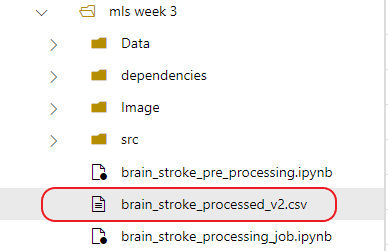

In [26]:
display.Image("Image/Image10.png")

### Deploy MLflow model to online endpoints with a custom environment and scoring script

#### Import the required libraries

In [27]:
# import required libraries
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    Environment,
    CodeConfiguration,
)
from azure.ai.ml.constants import AssetTypes

#### Create Online Endpoint

Online endpoints are endpoints that are used for online (real-time) inferencing. Online endpoints contain deployments that are ready to receive data from clients and can send responses back in real time.

To create an online endpoint we will use `ManagedOnlineEndpoint`. This class allows user to configure the following key aspects such as `name`,`auth_mode`,`identity`,etc.


#### Configure the endpoint

In [28]:
# Importing the required modules
import random
import string

# Creating a unique endpoint name by including a random suffix

# Defining a list of allowed characters for the endpoint suffix
allowed_chars = string.ascii_lowercase + string.digits

# Generating a random 5-character suffix for the endpoint name by choosing
# characters randomly from the list of allowed characters
endpoint_suffix = "".join(random.choice(allowed_chars) for x in range(5))

# Creating the final endpoint name by concatenating a prefix string
# with the generated suffix string
endpoint_name = "pima-endpoint-" + endpoint_suffix


In [29]:
print(f"Endpoint name: {endpoint_name}")

Endpoint name: pima-endpoint-6d184


In [30]:
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name,  
    # Name of the endpoint, should be unique within your deployment
    description="An online endpoint serving an MLflow model for the pima classification task",
    # A string describing the purpose of the endpoint
    auth_mode="key",
    # Authentication mode to use for the endpoint (in this case, using an API key)
    tags={"foo": "bar"},
    # A dictionary of key-value pairs that can be used to tag the endpoint
)

#### Create the endpoint
Using the `MLClient` created earlier, we will now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

In [31]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://pima-endpoint-6d184.eastus2.inference.ml.azure.com/score', 'openapi_uri': 'https://pima-endpoint-6d184.eastus2.inference.ml.azure.com/swagger.json', 'name': 'pima-endpoint-6d184', 'description': 'An online endpoint serving an MLflow model for the pima classification task', 'tags': {'foo': 'bar'}, 'properties': {'createdBy': 'Juvlin Pinheiro', 'createdAt': '2024-10-28T02:27:21.565130+0000', 'lastModifiedAt': '2024-10-28T02:27:21.565130+0000', 'azureml.onlineendpointid': '/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourcegroups/juvlinresourcegroup/providers/microsoft.machinelearningservices/workspaces/juvlinworkspace/onlineendpoints/pima-endpoint-6d184', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/oeidp:533a1434-a3da-4b

**Note: Go to the Endpoints on the left to observe the newly created endpoint**

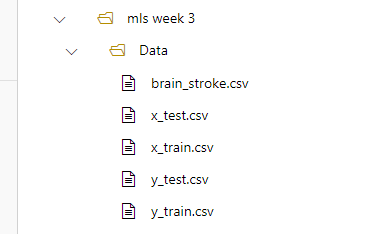

In [32]:
display.Image("Image/Image11.png")

#### Create a blue deployment

A deployment is a set of resources required for hosting the model that does the actual inferencing. We will create a deployment for our endpoint using the `ManagedOnlineDeployment` class. This class allows user to configure key aspects.

**Prerequisite: Go to the Models--> select the best-registered model ("pima_best_model")--> Artifacts--> Clone the directory ("pima_decisiontree_model") [download the directory and upload it in a folder with a name "pima_best_model" in your workspace] **

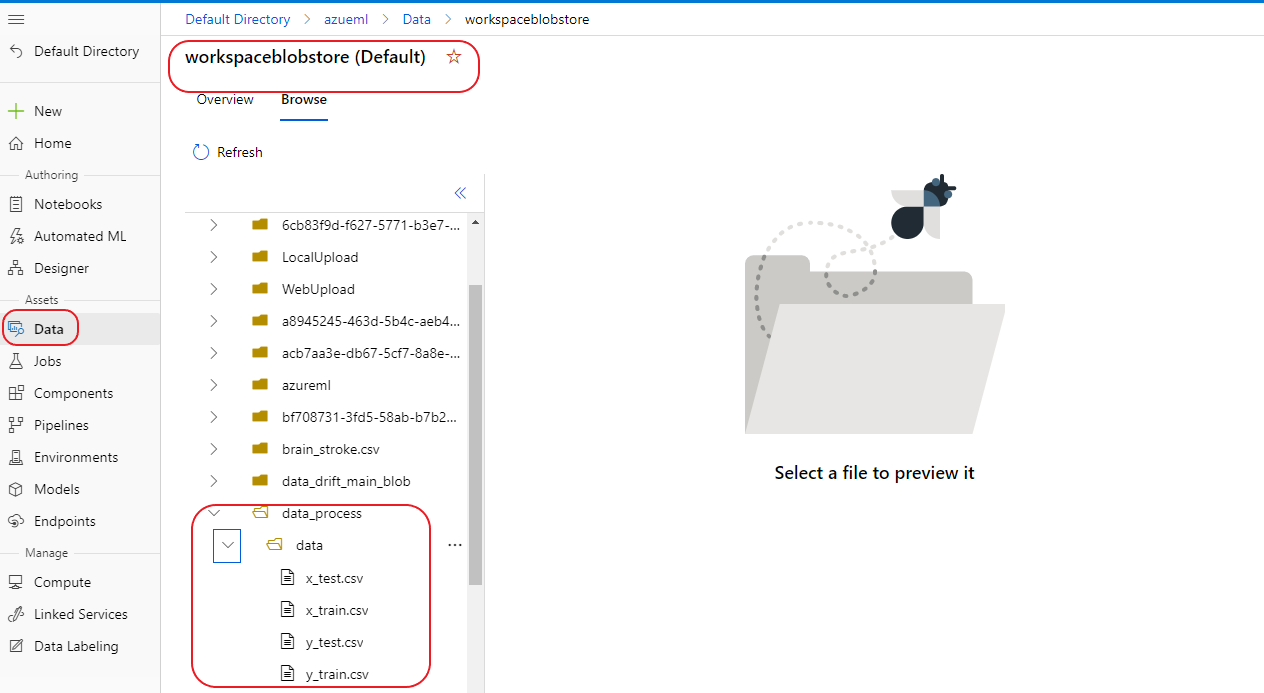

In [33]:
display.Image("Image/Image12.png")

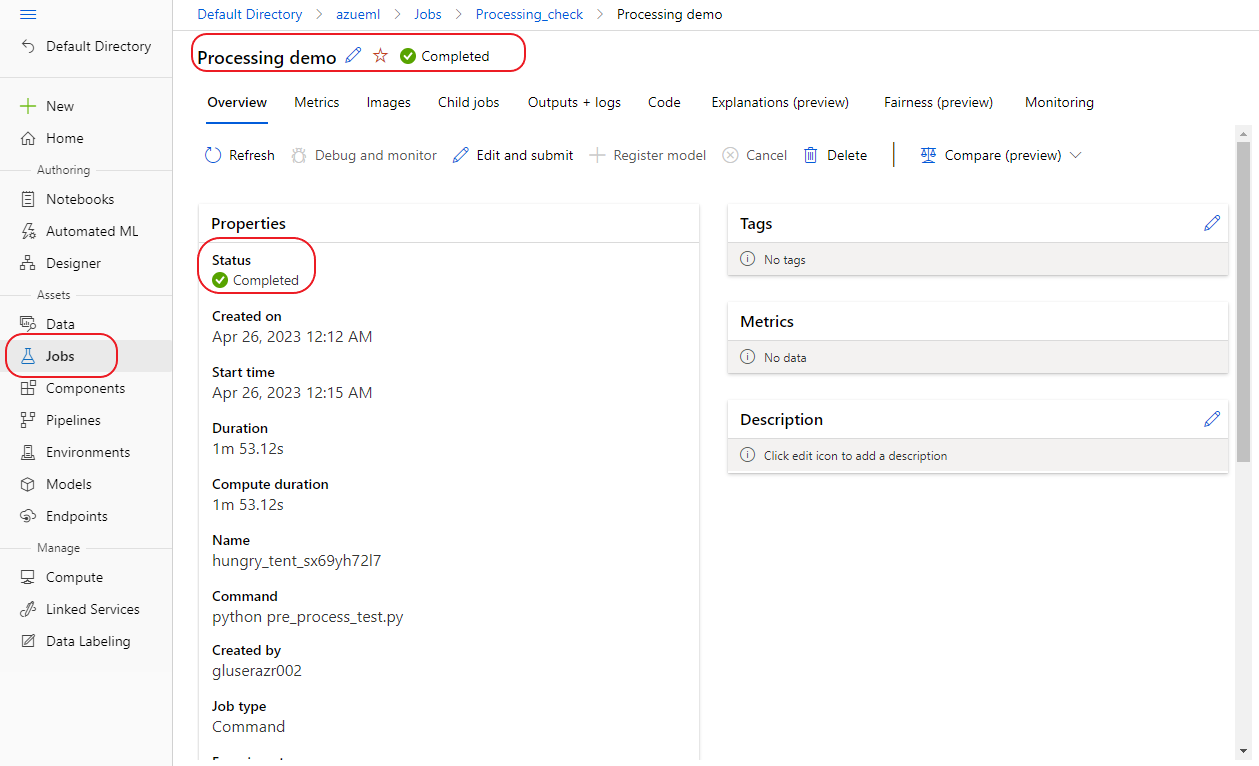

In [34]:
display.Image("Image/Image13.png")

**Registering the model:**

In [35]:
model_name = "pima_best_model"

model = Model(
    name=model_name,
    #The name of the MLflow model.
    path="pima_best_model/pima_decisiontree_model",
    #Path to the root directory of the model.
    type=AssetTypes.MLFLOW_MODEL,
    #The type of the model asset(MLflow model).
    description="MLflow model for the pima classification problem",
    #The purpose of the model.
)

##### Curating the deployment script:

**The script is split into two main functions:**

* **init()**: This function is responsible for loading the trained ML model. It uses the mlflow library to load the model from the AZUREML_MODEL_DIR environment variable. The input_schema variable is also set in this function by extracting it from the model metadata.


* **run(raw_data)**: This function accepts raw data in JSON format, parses the input data from the request, and scores the data using the loaded ML model. The input data is extracted from the json_data object and transformed into the expected input format for the model using infer_and_parse_json_input function from mlflow.pyfunc.scoring_server module. The model's predict() function is then called to generate predictions. The input data and the predictions are logged using the logger.info() function, with the logger object being initialized in the code's beginning. Finally, the predictions are converted to JSON format using the predictions_to_json() function from mlflow.pyfunc.scoring_server module and returned as a string.

The code also initializes a logger object to log messages to Azure Application Insights using the AzureLogHandler from the opencensus.ext.azure.log_exporter library. The connection string to the Application Insights instance is provided in the application_insights_connection_string variable.

Overall, the code performs the necessary steps to load a trained ML model and score data using that model, while also logging relevant information to Azure Application Insights.

**Important note: How to extract application insight connection string utilized in the script:**

In [36]:
display.Image("Image/Image14.png")

FileNotFoundError: No such file or directory: 'Image/Image14.png'

**Go to the Microsoft Azure home page and search for Application Insights --> Copy the Connection String and use it in the score.py script.**

In [ ]:
display.Image("Image/Image15.png")

In [ ]:
%%writefile {src_dir}/score.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=e040f1cb-4a7a-4009-87be-7861c813da51;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "pima_decisiontree_model")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json.dumps(json_data["input_data"])
    data = infer_and_parse_json_input(serving_input, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()


**Curating the deployment:**

In [42]:
# Create a new deployment with name "blue"
blue_deployment = ManagedOnlineDeployment(
    name="blue",
    # Use the previously generated endpoint name
    endpoint_name=endpoint_name,
    # Use the registered model
    model=registered_model,
    # Use the latest environment named "machine_learning_E2E"
    environment="machine_learning_E2E@latest",
    # Use the code in the "./src" directory and the "score.py" script
    code_configuration=CodeConfiguration(
        code="./src", scoring_script="score.py"
    ),
    # Use a single instance of type "Standard_E2s_v3"
    instance_type="Standard_E2s_v3",
    instance_count=1,
    # Enable Application Insights for the deployment
    app_insights_enabled=True,
)

#### Create the deployment

Using the `MLClient` created earlier, we will now create the deployment in the workspace. This command will start the deployment creation and return a confirmation response while the deployment creation continues.

In [43]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint pima-endpoint-6d184 exists


........

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'pima-endpoint-6d184', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/providers/Microsoft.MachineLearningServices/locations/eastus2/mfeOperationsStatus/odidp:533a1434-a3da-4be8-bff0-922142657211:be02ceab-2acd-4028-b76c-aa2770aa1045?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/6793e723-756c-4c5d-84c0-812f1bb4c679/resourceGroups/JuvlinResourceGroup/providers/Microsoft.MachineLearningServices/workspaces/JuvlinWorkspace/onlineEndpoints/pima-endpoint-6d184/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/pinhe512611/code/Users/pinhe51261/Code', 'creation_context': <azure.ai.ml._restclient.v2023_04_01_preview.models._model

#### Test the deployment

Using the `MLClient` created earlier, we will get a handle to the endpoint. The endpoint can be invoked using the invoke command.

We will send a sample request using a [sample-request-sklearn-custom.json]file.

In [44]:
ml_client.online_endpoints.invoke(
    #Name of the endpoint
    endpoint_name=endpoint_name,
    #Name of the specific deployment to test in an endpoint
    deployment_name="blue",
    #File with request data for testing
    request_file="sample-request-sklearn.json",
)

FileNotFoundError: [Errno 2] No such file or directory: 'sample-request-sklearn.json'

### Delete the deployment and endopoint

In [ ]:
ml_client.online_endpoints.begin_delete(name=endpoint_name)

## Important information: Upload the image directory to your workspace files before running the notebook in your Azure workspace to view all the accompanying screenshots.